In [17]:
# libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Global Wheat Detection Dataset
This particular dataset was chosen since it is one of the benchmark datasets which have been repliacted numorous times and is good for model comparison. That meaning, the researcher knows what the results will approximately be prior to the model training, so if an error is made it could be spotted easily. 

This agricultural datasets explores how pesticites and plant ilnesses can be can be categorized, and is significant since the prior detection of these ilnesses can save the neighbouring plants life, and minimize the economic cost. The lables of the dataset are the following: Yellow Rust, Mildew, Brown Rust, Common Root Rot, Blast, Mite, Septoria, Healthy, Leaf Blight, Black Rust.

Dataset link: https://www.kaggle.com/datasets/kushagra3204/wheat-plant-diseases


In [18]:
import os

print(os.listdir('/kaggle/input/wheat-plant-diseases/data/train')[:10])  # show first 10 files


['Yellow Rust', 'Mildew', 'Brown Rust', 'Common Root Rot', 'Blast', 'Mite', 'Septoria', 'Healthy', 'Leaf Blight', 'Black Rust']


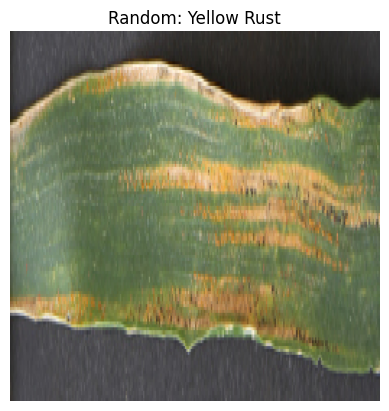

In [19]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import warnings

# DATA VISUALIZATION
folder = '/kaggle/input/wheat-plant-diseases/data/train/Yellow Rust'
filename = random.choice(os.listdir(folder))
YellowRust_img = Image.open(os.path.join(folder, filename))

# Kaggle needs matplotlib to show the actual photo
plt.imshow(YellowRust_img) # the image of yellow rust
plt.axis('off')  # remove axis ticks
plt.title("Random: Yellow Rust")
plt.show()



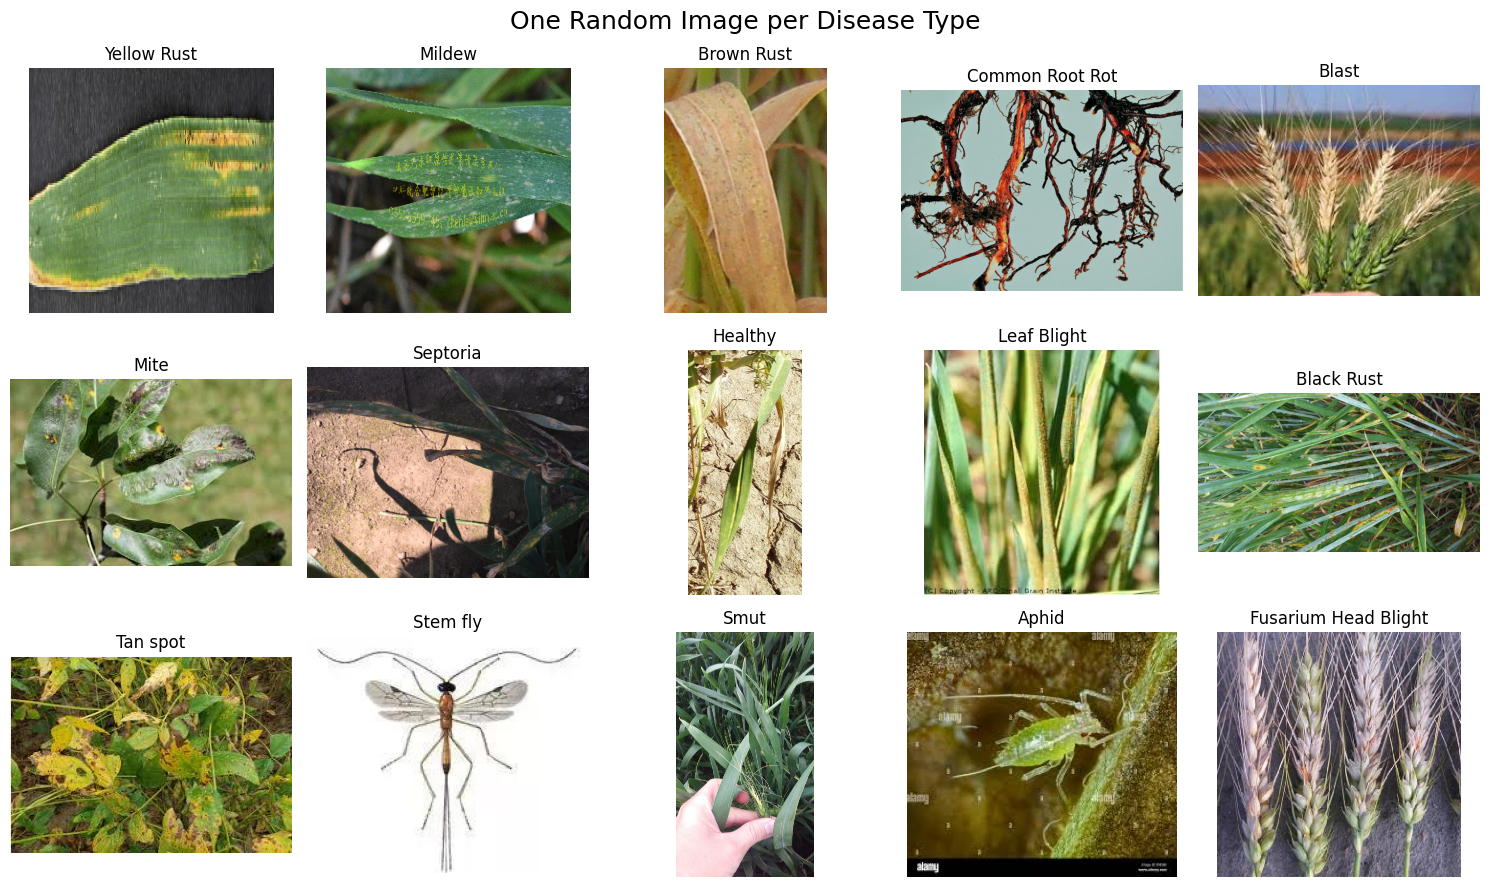

In [20]:

# Suppress warnings 
warnings.filterwarnings("ignore")

# Path to all disease folders
base_path = '/kaggle/input/wheat-plant-diseases/data/train'

# List of folders (disease names)
disease_classes = os.listdir(base_path)
num_classes = len(disease_classes)

# Calculate grid size 
cols = 5
rows = (num_classes + cols - 1) // cols  # ceiling division

# Create plot
plt.figure(figsize=(cols * 3, rows * 3))

for i, disease in enumerate(disease_classes):
    class_path = os.path.join(base_path, disease)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    
    img = Image.open(image_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(disease)

plt.suptitle("One Random Image per Disease Type", fontsize=18)
plt.tight_layout()
plt.show()


# General Outline 

1) Prepearing data
2) Creation of Data Loaders
3) Creation of Model (convolution- activation function- pooling- fully connected)
4) Define loss function
5) Try optimizers
6) Train the Model
7) Evaluation of Model
8) Hyperparameter Tuning


# Data Preprocessing 

After a random selection of photos were visulized with matplotlib, it is time to split the data into train, validation and test sets. The validation set is crucial here, since it will enable us to do hyperparameter tunning without data leakage which happens when the test set is used a few times. 

Data augmentation which is saying one introduces more noise in the training set, enables the model to train in diverse conditions and only is applied in the training set. In this example the pictures were rotated and flipped.

In [21]:
#Initialization of Datasets
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_dir = '/kaggle/input/wheat-plant-diseases/data'

# DATA AUGMENTATION ON THE TRAINING SET ONLY
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
# TRAIN, TEST, VALIDATION SET
# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
valid_data = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=valid_test_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=valid_test_transforms)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)



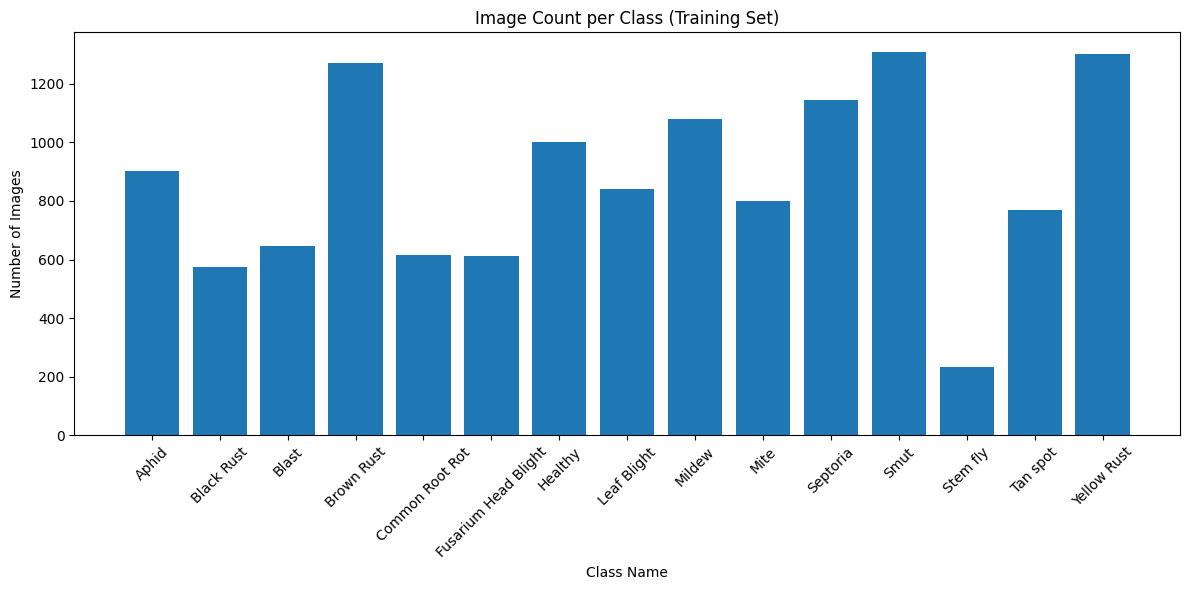

In [22]:
from collections import defaultdict

# VISAULIZATION OF EVERY CLASS COUNT

# class occurances
class_counts = defaultdict(int)
for _, label in train_data.samples:
    class_name = train_data.classes[label]
    class_counts[class_name] += 1

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.title("Image Count per Class (Training Set)")
plt.tight_layout()
plt.show()


# Method and Methodology

A short outline of what is planned could be usefful in this context. After the data is prepeared and turned into tensors, the image dataset has to be prepared. 

## The Research Question

Throughout 15,000 images of various plant disease, the aim of this project is to detect the class of the plant from 15 possible classes (including healthy). For this aim, a convolutional neural network architecture has been created with 3 layers, Rectified Linear Unit (ReLU) as its activation function, maximum pooling for feature extraction and downsampling. The kernel (filter used) size used is 3x3 in this case, and the padding is 1.

## Summary of Architecture
The convolution layer is profound to this model and it follows the sequence of convolution- activation function (Rectified Linear Unit in this case ReLU)- pooling (average pooling was prefered). After the layers are flatted for the dense layer step also called fully connected.



In [23]:

import torch.nn.functional as F

class WheatCNN(nn.Module):
    def __init__(self):
        super(WheatCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # input: 128x128x3 → 128x128x32
        self.pool1 = nn.MaxPool2d(2, 2)     #max pooling used since it is better at detecting strong features                        # 128x128x32 → 64x64x32

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # → 64x64x64
        self.pool2 = nn.MaxPool2d(2, 2)                             # → 32x32x64

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # → 32x32x128
        self.pool3 = nn.MaxPool2d(2, 2)                             # → 16x16x128

        self.dropout = nn.Dropout(0.3) # 30% to prevent overfitting, neurons are inactivated

        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # fully connected
        self.fc2 = nn.Linear(256, 15)             # 15 output classes

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 16 * 16)  # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



# Model Loss & Optimizer Function

Cross Entropy Loss function (objective function) was used instead of sum of squared Errors in this case, since the research question is a classification problem. Adaptive Moment Estimator was used as the optimization function, in this case the Stochastic Gradient Descent could also be used, however the literature states the prior might provide better results.

In [24]:
import torch.optim as optim
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Enable benchmark mode in cuDNN for faster training on fixed-size inputs
torch.backends.cudnn.benchmark = True

# Move model to device (GPU or CPU)
model = WheatCNN().to(device)

criterion = nn.CrossEntropyLoss() #the loss function 
#this loss function was used instead of sum of squared error since the data is multiclassed

optimizer = optim.Adam(model.parameters(), lr=0.005) #the optimizer function to improve performance 
#adaptive moment estimation

Using device: cpu


# Training of Models and Visualization of Epochs

The training was done and the loss function was visualized in terms of the epochs. One can see that the 5th epoch has the least value for the lost function and that the model is improving in every epoch so one can say that it is learning.

In [26]:
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 2.6667
Epoch 2, Loss: 2.0834
Epoch 3, Loss: 1.8932
Epoch 4, Loss: 1.7462
Epoch 5, Loss: 1.6311


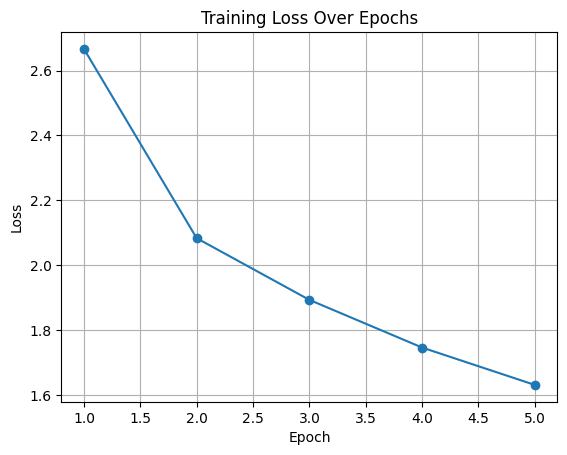

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()


# Evaluation of Model

The evaluation  of the model was done on the validation set since some hyperparameter tuning is planned after this process. The accuracy level received is not very promising owing it refers to the model being slightly better than random guessing (55%)

In [35]:
# Use validation set 
valid_loader = DataLoader(valid_data, batch_size=best_params['batch_size'], shuffle=False)

correct = 0
total = 0

best_model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"\n Validation Accuracy with best model: {val_acc:.2f}%")



 Validation Accuracy with best model: 54.67%


# Save and Load Model 

In [29]:
# Save model weights
torch.save(model.state_dict(), "wheat_disease_cnn.pth")

# Load them back later
model.load_state_dict(torch.load("wheat_disease_cnn.pth"))
model.eval()  # set to evaluation mode


WheatCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=15, bias=True)
)

# Deployment of Model 

 True label:      aphid_test
Predicted label: Aphid


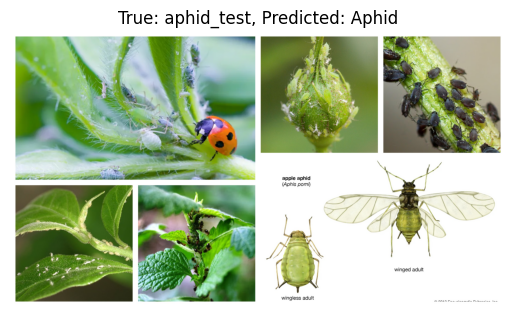

In [30]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Get one image from the test set
img_path, class_index = test_data.samples[0]  # any image
true_class = test_data.classes[class_index]

# Apply transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

img = Image.open(img_path)
input_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension and move to GPU

# Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)

print(" True label:     ", true_class)
print("Predicted label:", train_data.classes[predicted_class.item()])

# Optional: Show the image
plt.imshow(img)
plt.title(f"True: {true_class}, Predicted: {train_data.classes[predicted_class.item()]}")
plt.axis("off")
plt.show()


# Hyperparameter Tuning 
Some hyperparameters could be shown as learning rate, the functions and algorithms used in the model (such as the activation function being Rectified Linear Unit ReLU or a step function, or the loss function being Sum of Squared Error or Cross Entropy). It is known that when a model is used inappropriately meaning that it does not value the distinctive features of the dataset, this results in underfitting. The inverse happens when the training data is learned by the model too well, but the test results are bad which is called overfitting. 

Some prerequirements are made like normalization to overcome overfitting, however after the performance indices are analyzed, the researcher can improve their model by introducing noise to the training set.

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

batch_sizes = [64, 128]
learning_rates = [0.001, 0.0005]
epochs = 5

best_accuracy = 0.0
best_model = None
best_params = {}


for batch_size in batch_sizes:
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    for lr in learning_rates:
        print(f"\n Trying batch_size={batch_size}, learning_rate={lr}")
        model = WheatCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0

            for images, labels in train_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

        #  Validation accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc:.2f}%")

        # Save best model based on validation
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model = model
            best_params = {'batch_size': batch_size, 'learning_rate': lr}

print("\n Best Hyperparameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")



 Trying batch_size=64, learning_rate=0.001


In [36]:
# Use test_loader and the best model from above
test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

correct = 0
total = 0

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"\n Final Test Accuracy with best model: {test_acc:.2f}%")



 Final Test Accuracy with best model: 56.27%


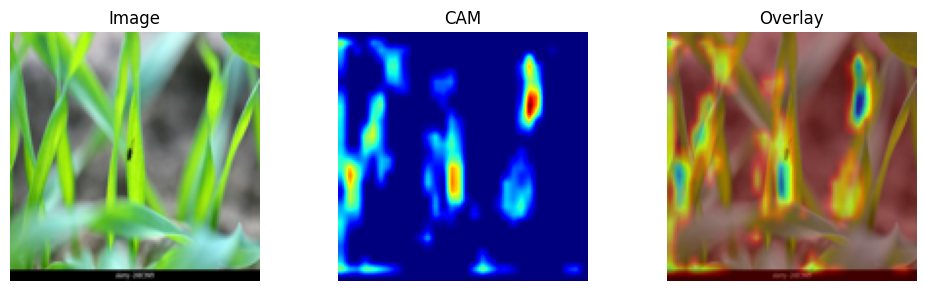

 Predicted class: Aphid
 True label     : Aphid


In [34]:
import cv2
import numpy as np
# Grad cam visualization
model = WheatCNN().to(device)
model.load_state_dict(torch.load("wheat_disease_cnn.pth", map_location=device))
model.eval()

# Pick a validation image (change the index if you want)
idx = 0
image_tensor, label = valid_data[idx]
input_tensor = image_tensor.unsqueeze(0).to(device)  # shape: [1, 3, 128, 128]
original_img = np.array(Image.open(valid_data.samples[idx][0]).resize((128, 128)))

# Forward hook
features = []
gradients = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register on the last conv layer
hook_f = model.conv3.register_forward_hook(forward_hook)
hook_b = model.conv3.register_backward_hook(backward_hook)

# Forward & backward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
model.zero_grad()
output[0, pred_class].backward()

# Remove hooks
hook_f.remove()
hook_b.remove()

# Get feature maps and gradients
grad = gradients[0][0]  # shape: [128, 16, 16]
feat = features[0][0]   # shape: [128, 16, 16]
weights = grad.mean(dim=(1, 2))  # shape: [128]

# Compute CAM
cam = torch.sum(weights[:, None, None] * feat, dim=0)
cam = F.relu(cam)
cam = cam - cam.min()
cam = cam / cam.max()
cam = cam.cpu().detach().numpy()
cam = cv2.resize(cam, (128, 128))

# Overlay on image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original_img, 0.5, heatmap, 0.5, 0)

# Plot
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1); plt.title("Image"); plt.imshow(original_img); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("CAM"); plt.imshow(cam, cmap='jet'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.tight_layout(); plt.show()

print(f" Predicted class: {train_data.classes[pred_class]}")
print(f" True label     : {train_data.classes[label]}")